<a href="https://colab.research.google.com/github/PomesHouse/SkillTreePython-DeepLearning/blob/main/03.NLP-with-tensorflow2.0/ch03_04_%EC%88%9C%ED%99%98%EC%8B%A0%EA%B2%BD%EB%A7%9D_Bidirectional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch03.04_순환신경망 - Bidirectional-LSTM
---

* 날짜:
* 이름:


## 학습내용
    - 순환 신경망에 대해 이해한다.
    - BiLSTM
    - 로이터 뉴스기사 카테고리 분류
    - 스팀 리뷰 걈성 분류

```
! git clone https://github.com/yebiny/SkillTreePython-DeepLearning
```

In [ ]:
! git clone https://github.com/yebiny/SkillTreePython-DeepLearning

Cloning into 'SkillTreePython-DeepLearning'...
remote: Enumerating objects: 735, done.
remote: Counting objects: 100% (308/308), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 735 (delta 187), reused 255 (delta 155), pack-reused 427
Receiving objects: 100% (735/735), 38.42 MiB | 16.84 MiB/s, done.
Resolving deltas: 100% (380/380), done.


```
import sys
sys.path.append('/content/SkillTreePython-DeepLearning/scripts')
from import_lib import *
from plot_result import *
```

In [ ]:
import sys
sys.path.append('/content/SkillTreePython-DeepLearning/scripts')
from import_lib import *
from plot_result import *

## 로이터 뉴스 기사 분류
---

### | 데이터 전처리 

#### **데이터 불러오기**

In [ ]:
MAX_FEATURES = 1000 # 데이터에 1000(-1)개 단어만 포함하기
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.reuters.load_data(num_words = MAX_FEATURES)
print('훈련데이터:',x_train.shape, y_train.shape)
print('테스트데이터:',x_test.shape, y_test.shape)

2121728/2110848 [==============================] - 0s 0us/step
훈련데이터: (8982,) (8982,)
테스트데이터: (2246,) (2246,)


#### **데이터 확인**

In [ ]:
print('첫번째 기사', x_train[0]) # 토큰화, 단어 인덱싱이 된 상태
print('첫번째 기사의 카테고리', y_train[0])
print('카테고리 개수:', np.max(y_train)+1) # 클래스가 0 ~ 45

첫번째 기사 [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
첫번째 기사의 카테고리 3
카테고리 개수: 46


In [ ]:
word2index = tf.keras.datasets.reuters.get_word_index()
print(word2index)

565248/550378 [==============================] - 0s 0us/step
{'mdbl': 10996, 'fawc': 16260, 'degussa': 12089, 'woods': 8803, 'hanging': 13796, 'localized': 20672, 'sation': 20673, 'chanthaburi': 20675, 'refunding': 10997, 'hermann': 8804, 'passsengers': 20676, 'stipulate': 20677, 'heublein': 8352, 'screaming': 20713, 'tcby': 16261, 'four': 185, 'grains': 1642, 'broiler': 20680, 'wooden': 12090, 'wednesday': 1220, 'highveld': 13797, 'duffour': 7593, '0053': 20681, 'elections': 3914, '270': 2563, '271': 3551, '272': 5113, '273': 3552, '274': 3400, 'rudman': 7975, '276': 3401, '277': 3478, '278': 3632, '279': 4309, 'dormancy': 9381, 'errors': 7247, 'deferred': 3086, 'sptnd': 20683, 'cooking': 8805, 'stratabit': 20684, 'designing': 16262, 'metalurgicos': 20685, 'databank': 13798, '300er': 20686, 'shocks': 20687, 'nawg': 7972, 'tnta': 20688, 'perforations': 20689, 'affiliates': 2891, '27p': 20690, 'ching': 16263, 'china': 595, 'wagyu': 16264, 'affiliated': 3189, 'chino': 16265, 'chinh': 162

뉴스 기사의 평균길이: 145.5398574927633


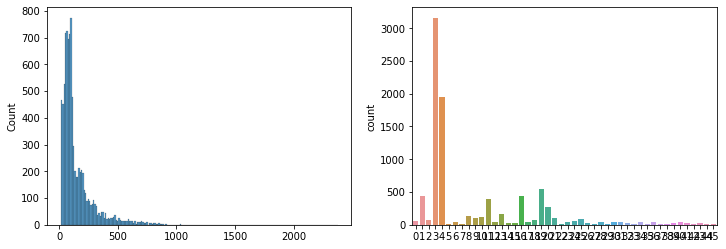

In [ ]:
# 뉴스 기사의 평균 길이
plt.figure(figsize = (12, 4))
len_sample = [len(x) for x in x_train]
plt.subplot(121); sns.histplot(x = len_sample)
plt.subplot(122); sns.countplot(x = y_train)
print('뉴스 기사의 평균길이:', np.mean(len_sample))

In [ ]:
# 데이터 전처리: 패딩 
MAX_LEN = 128
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen = MAX_LEN)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen = MAX_LEN)
print('훈련데이터:',x_train.shape, y_train.shape)
print('테스트데이터:',x_test.shape, y_test.shape)

훈련데이터: (8982, 128) (8982,)
테스트데이터: (2246, 128) (2246,)


### | 임베딩 매트릭스 제작

```
! gdown https://drive.google.com/u/0/uc?id=1ams5_zp8NrfmbxSzTDCglRpAvjFGi5JY&export=download
! unzip  /content/glove.6B.zip
```


In [32]:
! gdown https://drive.google.com/u/0/uc?id=1SskmaqNEYmXSADf3opvqoova08078lJV&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1SskmaqNEYmXSADf3opvqoova08078lJV
To: /content/glove.6B.100d.txt
100% 347M/347M [00:06<00:00, 49.9MB/s]


In [33]:
# ! unzip  /content/glove.6B.zip

unzip:  cannot find or open /content/glove.6B.zip, /content/glove.6B.zip.zip or /content/glove.6B.zip.ZIP.


#### **단어-임베딩 딕셔너리**

```
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
```

In [34]:
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

#### **인덱싱-단어 딕셔너리**

In [ ]:
word2index = tf.keras.datasets.reuters.get_word_index()
#print(word2index)
index2word = {}
for word, index in word2index.items():
#    print(word, index)
    index2word[index + 3] = word
print(index2word)

In [ ]:
for x in x_train[0]:
    if index2word.get(x) is not None:
        print(index2word[x]) # 1000개 단어 외에는 생략되기 때문에 

#### **매트릭스 제작**

In [35]:
EMB_DIMS=100
embedding_matrix = np.zeros((MAX_FEATURES, EMB_DIMS))
print('임베딩 매트릭스 (W): ' , embedding_matrix.shape)
for i in range(1, MAX_FEATURES):
  idx=i+4
  word = index2word.get(idx)
  vec = embeddings_index.get(word)
  if vec is not None:
    embedding_matrix[i]=vec
    #print(i, idx, word, vec)

임베딩 매트릭스 (W):  (1000, 100)


### | 모델학습 1

이때까지 배운 레이어를 사용하여 모델을 구축하세요.

```
Embedding()
RNN()
LSTM()
GRU()
GlobalAveragePooling1D()
Dense()
```

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 128)]             0         
                                                                 
 embedding_22 (Embedding)    (None, 128, 100)          100000    
                                                                 
 gru_26 (GRU)                (None, 128, 64)           31872     
                                                                 
 gru_27 (GRU)                (None, 128, 64)           24960     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_17 (Dense)            (None, 46)                2990      
                                                          

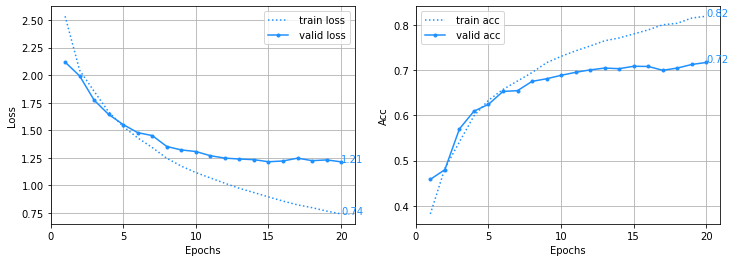

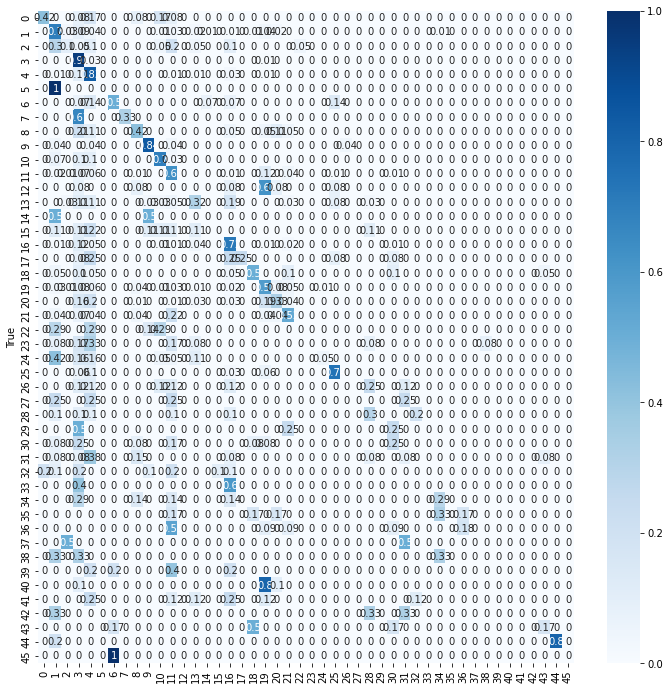

In [36]:
# 레이어를 조합해서 72% 이상 
EMB_DIMS = 100
x = layers.Input(shape = MAX_LEN)
y = layers.Embedding(MAX_FEATURES, EMB_DIMS)(x)
y = layers.GRU(64, return_sequences = True,)(y) 
#                input_shape = (MAX_FEATURES, EMB_DIMS))(y)
y = layers.GRU(64, return_sequences = True)(y)
y = layers.GlobalAveragePooling1D()(y)
y = layers.Dense(46, activation = 'softmax')(y)
model = models.Model(x, y)

model.layers[1].set_weights([embedding_matrix])
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])
model.summary()
history = model.fit(x_train, y_train, 
                    batch_size = 128,
                    epochs = 20,
                    validation_data = (x_test, y_test))
plot_lcurve([history], [''], ['dodgerblue'], x_itv = 5)
draw_cm(model, x_test, y_test) # 스크립트-혼돈행렬 플롯

### | 모델학습 2

![](https://www.researchgate.net/profile/Arvind-Mohan-3/publication/324769532/figure/fig2/AS:619510805561344@1524714294669/LSTM-and-BiLSTM-Architectures.png)

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 128)]             0         
                                                                 
 embedding_23 (Embedding)    (None, 128, 100)          100000    
                                                                 
 bidirectional (Bidirectiona  (None, 128, 128)         63744     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128, 128)         74496     
 nal)                                                            
                                                                 
 global_average_pooling1d_2   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                          

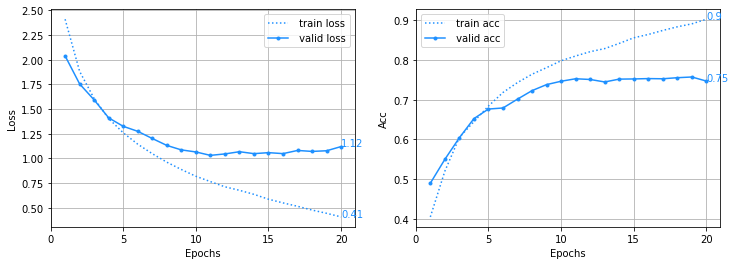

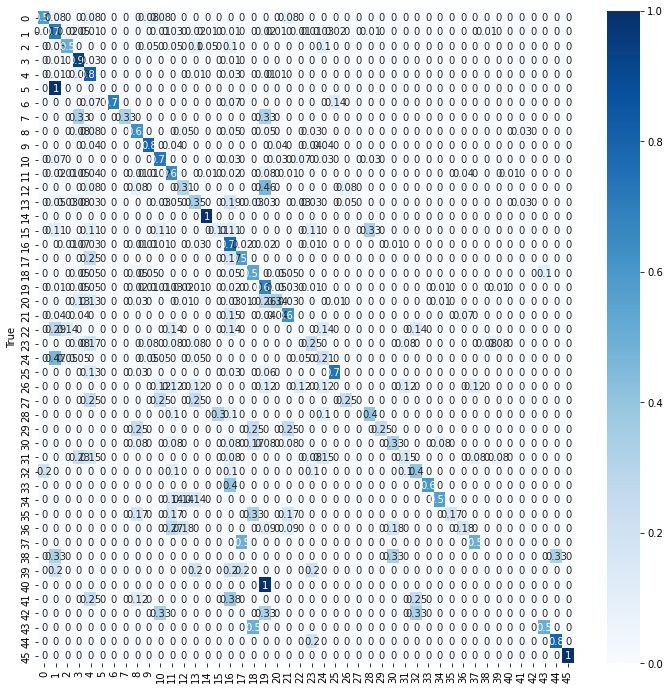

In [39]:
# 레이어를 조합해서 72% 이상 
EMB_DIMS = 100
x = layers.Input(shape = MAX_LEN)
y = layers.Embedding(MAX_FEATURES, EMB_DIMS)(x)
y = layers.Bidirectional(layers.GRU(64, return_sequences = True,))(y) 
#                input_shape = (MAX_FEATURES, EMB_DIMS))(y)
y = layers.Bidirectional(layers.GRU(64, return_sequences = True))(y)
y = layers.GlobalAveragePooling1D()(y)
y = layers.Dense(46, activation = 'softmax')(y)
model = models.Model(x, y)

model.layers[1].set_weights([embedding_matrix])
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])
model.summary()
history = model.fit(x_train, y_train, 
                    batch_size = 128,
                    epochs = 20,
                    validation_data = (x_test, y_test))
plot_lcurve([history], [''], ['dodgerblue'], x_itv = 5)
draw_cm(model, x_test, y_test) # 스크립트-혼돈행렬 플롯

## 스팀 리뷰 감성 분류
---

https://wikidocs.net/94748

```
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
```

In [40]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 31.73 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 65.5 MB/s 
     |████████████████████████████████| 453 kB 58.0 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-07-18 01:25:20--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22cd:e0db, 2406:da00:ff00::22e9:9f55, ...
Connecting to bitbucket.org (

### 스팀 리뷰 데이터에 대한 이해와 전처리

In [42]:
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#### 데이터 로드하기

In [43]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x7f6742367810>)

In [44]:
# 해당 데이터에는 열제목 x -> 임의로 열제목 'label'과 'reviews'를 추가
total_data = pd.read_table('steam.txt', names = ['label', 'reviews'])
print('전체 리뷰 개수:', len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수: 100000


In [46]:
total_data[:5]

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [47]:
# 각 열에 대해서 중복을 제외한 샘플의 수를 카운트
total_data['reviews'].nunique(), total_data['label'].nunique()

(99892, 2)

In [48]:
# reviews 열에서 중복인 내용이 있다면 중복 제거
total_data.drop_duplicates(subset = ['reviews'], inplace = True) 
print('총 샘플의 수:', len(total_data))

총 샘플의 수: 99892


In [49]:
# NULL 값 유무 확인
print(total_data.isnull().values.any())

False


#### 훈련 데이터와 테스트 데이터 분리

In [50]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수:', len(train_data))
print('테스트용 리뷰의 개수:', len(test_data))

훈련용 리뷰의 개수: 74919
테스트용 리뷰의 개수: 24973


#### 레이블 분포 확인

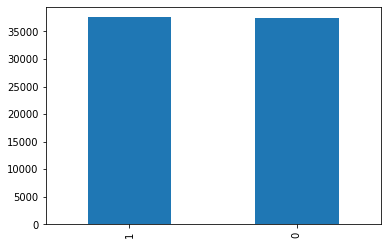

In [51]:
train_data['label'].value_counts().plot(kind = 'bar')

In [52]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  37376
1      1  37543


#### 데이터 정제

In [55]:
# train datasets
# 정규 표현식을 사용하여 한글을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 위 과정에서 혹시 생긴 빈 샘플 확인
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

label      0
reviews    0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [56]:
# test datsets
test_data.drop_duplicates(subset = ['reviews'], inplace = True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace = True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how = 'any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수:', len(test_data))


전처리 후 테스트용 샘플의 개수: 24973


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [57]:
# 불용어 정의
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', 
             '하', '고', '을', '를', '인', '듯', '과', '와', '네', 
             '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

#### 토큰화

In [58]:
# 형태소 분석기 Mecab을 사용하여 토큰화
mecab = Mecab()

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

#### 단어와 길이 분포 확인

In [61]:
# 긍정/부정 리뷰에 주로 어떤 단어들이 많이 등장하는지 단어의 빈도수 계산
# 각 레이블에 따라서 별도로 단어들의 리스트를 저장해줍니다.
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [64]:
negative_words

array(['편', '나름', '재밌', ..., '금방', '끝', '남'], dtype='<U32')

In [62]:
# Counter()를 사용하여 각 단어에 대한 빈도수를 카운트
# 부정 리뷰에 대해서 빈도수가 높은 상위 20개 단어
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('안', 8129), ('없', 7141), ('는데', 5786), ('있', 5692), ('같', 4247), ('로', 4083), ('할', 3920), ('거', 3902), ('나', 3805), ('해', 3653), ('너무', 3522), ('으로', 3351), ('기', 3348), ('했', 3265), ('어', 3143), ('보', 2987), ('습니다', 2962), ('것', 2935), ('지만', 2911), ('좋', 2899)]


In [63]:
# 긍정 리뷰에 대해서 빈도수가 높은 상위 20개 단어
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('있', 9987), ('좋', 6542), ('습니다', 5179), ('재밌', 4997), ('할', 4838), ('지만', 4809), ('해', 4354), ('없', 4145), ('보', 3907), ('으로', 3900), ('로', 3879), ('수', 3835), ('는데', 3825), ('기', 3592), ('안', 3368), ('것', 3362), ('같', 3356), ('네요', 3189), ('어', 3112), ('나', 3055)]


긍정 리뷰의 평균 길이 : 14.948459100231734
부정 리뷰의 평균 길이 : 15.284193065068493


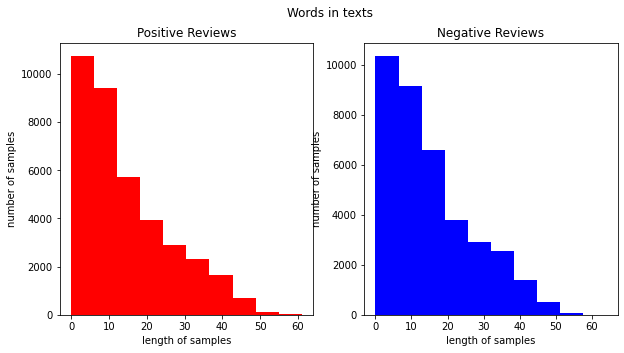

In [66]:
# 각각 길이 분포 확인
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [68]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [70]:
train_data

,label,reviews,tokenized
17152,1,게임 클리어 할 때까지 계속 새롭고 질리지 않습니다 정말 잘 만든 퍼즐 게임입니다 ...,"[클리어, 할, 때, 까지, 계속, 새롭, 질리, 않, 습니다, 정말, 잘, 만든,..."
59872,0,편 나름 재밌게 했으면 그걸로 멈추는게 좋았네,"[편, 나름, 재밌, 했, 으면, 그걸로, 멈추, 좋, 았]"
40613,0,할거 드럽게 없음,"[할, 거, 드럽, 없]"
80196,0,ㅈ까라 이건 그거 하나만으로도 살 가치가 없는 겜 내가 저거 때문에 이 겜 시에 ...,"[ㅈ, 까라, 이건, 그거, 하나, 으로, 살, 가치, 없, 내, 저거, 때문, 시..."
35283,0,돈 아깝다,"[돈, 아깝]"
...,...,...,...
6265,1,이쯤되면 생존자가 살인마,"[쯤, 생존자, 살인마]"
54920,1,시간때우기 매우좋은 게임 특히 군사전략게임을 좋아한다면 한번 해보는것을 추천한다,"[시간, 때우, 기, 매우, 좋, 특히, 군사, 전략, 좋, 아, 한다면, 번, 해..."
76885,1,스팀에 출시돼고 나서야 알게되었지만 지금이라도 알게돼 다행이다 나는 비시즈를 좋아하...,"[스팀, 출시, 돼, 나서, 야, 알, 었, 지만, 지금, 라도, 알, 돼, 다행이..."
860,0,점프도 어렵고 금방 끝남,"[점프, 어렵, 금방, 끝, 남]"


In [69]:
X_train

array([list(['클리어', '할', '때', '까지', '계속', '새롭', '질리', '않', '습니다', '정말', '잘', '만든', '퍼즐', '입니다', '추천', '합니다']),
       list(['편', '나름', '재밌', '했', '으면', '그걸로', '멈추', '좋', '았']),
       list(['할', '거', '드럽', '없']), ...,
       list(['스팀', '출시', '돼', '나서', '야', '알', '었', '지만', '지금', '라도', '알', '돼', '다행이', '나', '비시', '즈', '좋아하', '편', '라', '구입', '했', '비', '시즈', '비행기', '못', '만들', '거든요', '추천', '드립니다']),
       list(['점프', '어렵', '금방', '끝', '남']),
       list(['더', '워킹', '데드', '아직', '안', '해', '보', '셨', '나요', '스토리', '위주', '로', '진행', '선택', '형', '플레이', '방식', '인데요', '한편', '영화', '보', '좋', '겠', '습니다', '갈등', '연속', '정말', '재미있', '습니다', '도전', '과제', '때문', '번', '더', '리뷰'])],
      dtype=object)

#### 정수 인코딩

In [71]:
# 정수 인코딩: 기계가 텍스트를 숫자로 처리할 수 있도록 

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
# 훈련 데이터에 대한 단어 집합(vocaburary)이 생성 + 각 단어에 고유한 정수가 부여
# tokenizer.word_index를 출력하여 확인 가능

In [72]:
# 등장 횟수가 1회인 단어들은 자연어 처리에서 배제하고자 함

# 이 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32817
등장 빈도가 1번 이하인 희귀 단어의 수: 13878
단어 집합에서 희귀 단어의 비율: 42.28905750068562
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.2254607619437832


* 단어는 약 32,000개
* 등장 빈도가 threshold == 2 미만, 즉, 1회인 단어들이 약 42%
* 실제 훈련 데이터에서의 등장 빈도는 약 1.2%
    * 이 단어들은 정수 인코딩 과정에서 배제.  
    * 등장 빈도수가 1인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한

In [73]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기:', vocab_size)

단어 집합의 크기: 18941


In [75]:
X_train

array([list(['클리어', '할', '때', '까지', '계속', '새롭', '질리', '않', '습니다', '정말', '잘', '만든', '퍼즐', '입니다', '추천', '합니다']),
       list(['편', '나름', '재밌', '했', '으면', '그걸로', '멈추', '좋', '았']),
       list(['할', '거', '드럽', '없']), ...,
       list(['스팀', '출시', '돼', '나서', '야', '알', '었', '지만', '지금', '라도', '알', '돼', '다행이', '나', '비시', '즈', '좋아하', '편', '라', '구입', '했', '비', '시즈', '비행기', '못', '만들', '거든요', '추천', '드립니다']),
       list(['점프', '어렵', '금방', '끝', '남']),
       list(['더', '워킹', '데드', '아직', '안', '해', '보', '셨', '나요', '스토리', '위주', '로', '진행', '선택', '형', '플레이', '방식', '인데요', '한편', '영화', '보', '좋', '겠', '습니다', '갈등', '연속', '정말', '재미있', '습니다', '도전', '과제', '때문', '번', '더', '리뷰'])],
      dtype=object)

In [77]:
# 위 단어 집합을 토크나이저의 인자로 넘겨주면, 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환 
# 이 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [78]:
# 정수 인코딩 확인 
print(X_train[:3])

[[495, 7, 35, 87, 149, 2429, 599, 26, 8, 70, 47, 235, 111, 38, 44, 52], [161, 300, 18, 20, 63, 3582, 985, 6, 56], [7, 17, 1476, 4]]


In [79]:
print(X_test[:3])

[[728, 34, 16, 431, 52, 106, 132, 99, 6461, 453], [4527, 687, 835, 712, 792, 108, 4, 1779, 95, 370, 3518, 81, 558, 1904, 4189, 262, 169, 61, 25, 363, 35, 87, 974, 19, 6294, 6422], [1792, 806, 685, 49, 23, 349]]


#### 패딩

리뷰의 최대 길이 : 64
리뷰의 평균 길이 : 15.115951894712957


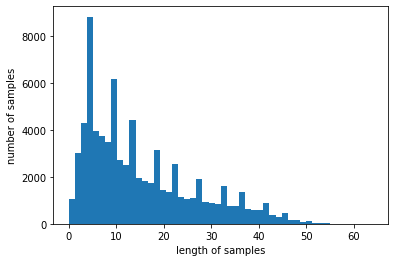

In [80]:
# 서로 다른 길이의 샘플들의 길이를 동일하게..

print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [81]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [82]:
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.99599567532935


In [83]:
# 훈련용 리뷰의 99.99%가 60이하의 길이 -> 훈련용 리뷰를 길이 60으로 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### BiLSTM으로 스팀 리뷰 감성 분류

In [84]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
234/235 [============================>.] - ETA: 0s - loss: 0.5241 - acc: 0.7416
Epoch 1: val_acc improved from -inf to 0.78223, saving model to best_model.h5
235/235 [==============================] - 10s 22ms/step - loss: 0.5241 - acc: 0.7416 - val_loss: 0.4687 - val_acc: 0.7822
Epoch 2/15
233/235 [============================>.] - ETA: 0s - loss: 0.4340 - acc: 0.8031
Epoch 2: val_acc improved from 0.78223 to 0.78637, saving model to best_model.h5
235/235 [==============================] - 4s 17ms/step - loss: 0.4338 - acc: 0.8032 - val_loss: 0.4623 - val_acc: 0.7864
Epoch 3/15
235/235 [==============================] - ETA: 0s - loss: 0.4075 - acc: 0.8177
Epoch 3: val_acc improved from 0.78637 to 0.78897, saving model to best_model.h5
235/235 [==============================] - 4s 18ms/step - loss: 0.4075 - acc: 0.8177 - val_loss: 0.4572 - val_acc: 0.7890
Epoch 4/15
234/235 [============================>.] - ETA: 0s - loss: 0.3855 - acc: 0.8293
Epoch 4: val_acc did not impr

### 리뷰 예측

In [87]:
# 임의의 문장에 대한 예측을 위해 학습하기 전 전처리를 동일하게 적용

def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  # score = float(loaded_model.predict(pad_new)) # 원본 코드
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [88]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')

98.15% 확률로 부정 리뷰입니다.


In [89]:
sentiment_predict('조금 어렵지만 재밌음ㅋㅋ')

97.76% 확률로 긍정 리뷰입니다.


In [90]:
sentiment_predict('케릭터가 예뻐서 좋아요')

92.74% 확률로 긍정 리뷰입니다.
